In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import pickle

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [3]:
routes_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/routes/')

experiments_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/vonmises_vs_cosine/experiments/')

T_outbound = 1500
T_inbound = 1500

In [22]:
rs_vm = [[],[]]
rs_cos = [[],[]]

for cpu4_method in [1,2]:
    for exp in range(100):
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        h = data['h']
        v = data['v']
        cx_log = data['cx_log']

        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        spiking_cx_vm = data['spiking_cx_vm']
        spiking_cx_cos = data['spiking_cx_cos']

#         plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,:8])
#         plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,8:])
#         plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][T_outbound,:])
#         plt.plot(cx_log.memory[:,T_outbound]*spiking_cx_vm['CPU4_memory_history'][T_outbound,:].max())
#         plt.show()
        
        s_vm = spiking_cx_vm['CPU4_memory_history'][T_outbound,:]
        s_cos = spiking_cx_cos['CPU4_memory_history'][T_outbound,:]
        s_t = cx_log.memory[:,T_outbound]
    
        rs_vm[cpu4_method-1].append(scipy.stats.pearsonr(s_vm,s_t)[0])
        rs_cos[cpu4_method-1].append(scipy.stats.pearsonr(s_cos,s_t)[0])

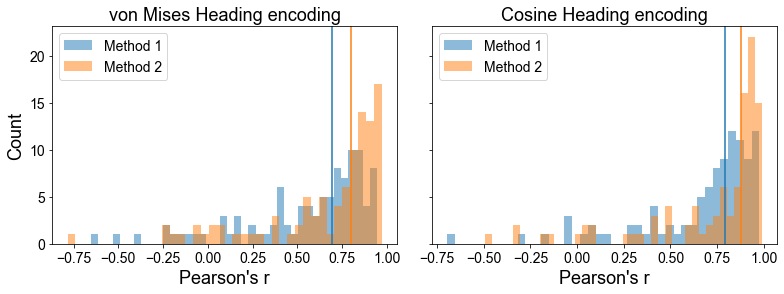

0.555579153779339 0.6614345112416413
0.6678039699337175 0.7257399149599878

0.6925022364419544 0.8025017452382432
0.7901854523236314 0.8781498087073486


In [51]:
fig, ax = plt.subplots(1,2, figsize=(13,4), sharey=True, gridspec_kw={'wspace': 0.1})



ax[0].hist(rs_vm[0], bins=40, alpha=0.5, color='tab:blue', label='Method 1')
ax[0].hist(rs_vm[1], bins=40, alpha=0.5, color='tab:orange', label='Method 2')
ax[0].axvline(np.median(rs_vm[0]), color='tab:blue')
ax[0].axvline(np.median(rs_vm[1]),  color='tab:orange')
# ax[0].axvline(np.mean(rs_vm[0]), ls='--', color='tab:blue')
# ax[0].axvline(np.mean(rs_vm[1]), ls='--', color='tab:orange')
ax[0].set_xlabel('Pearson\'s r', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)
ax[0].legend(loc='upper left')
ax[0].set_title('von Mises Heading encoding', fontsize=18)
# plt.show()

ax[1].hist(rs_cos[0], bins=40, alpha=0.5, color='tab:blue', label='Method 1')
ax[1].hist(rs_cos[1], bins=40, alpha=0.5, color='tab:orange', label='Method 2')
ax[1].axvline(np.median(rs_cos[0]), color='tab:blue')
ax[1].axvline(np.median(rs_cos[1]),  color='tab:orange')
# ax[1].axvline(np.mean(rs_cos[0]), ls='--', color='tab:blue')
# ax[1].axvline(np.mean(rs_cos[1]), ls='--', color='tab:orange')
ax[1].set_xlabel('Pearson\'s r', fontsize=18)

ax[1].legend()
ax[1].set_title('Cosine Heading encoding', fontsize=18)
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_memory_correlations.pdf'),
             bbox_inches='tight')

plt.show()

print(np.mean(rs_vm[0]), np.mean(rs_vm[1]))
print(np.mean(rs_cos[0]), np.mean(rs_cos[1]))
print()
print(np.median(rs_vm[0]), np.median(rs_vm[1]))
print(np.median(rs_cos[0]), np.median(rs_cos[1]))

In [63]:
def decode_cpu4(CPU4_memory):
    '''
    Shifts both CPU4 by +1 and -1 column to cancel 45 degree flow
    preference. When summed single sinusoid should point home.

    From Stone et al.
    '''
    cpu4_reshaped = CPU4_memory.reshape(2, -1)
    cpu4_shifted = np.vstack([np.roll(cpu4_reshaped[0], 1),
                              np.roll(cpu4_reshaped[1], -1)])
    return cpu4_shifted


def decode_position( cpu4_reshaped, cpu4_mem_gain=1):
    '''
    Decode position from sinusoid in to polar coordinates.
    Amplitude is distance, Angle is angle from nest outwards.
    Without offset angle gives the home vector.
    Input must have shape of (2, -1)

    From Stone et al.
    '''
    signal = np.sum(cpu4_reshaped, axis=0)
    fund_freq = np.fft.fft(signal)[1]
    angle = -np.angle(np.conj(fund_freq))
    distance = np.absolute(fund_freq) / cpu4_mem_gain
    return angle, distance

def decode_cpu4_state(CPU4_memory_history, bee_coords, step):
    decoded_cpu4 = decode_cpu4(CPU4_memory_history[step-1,:])
    cpu4_angle, distance = decode_position(decoded_cpu4)
    tb1_angle = math.atan2(bee_coords[step-1,1], bee_coords[step-1,0])
    return tb1_angle, cpu4_angle, distance

def make_angle( theta):
    '''
    Return an angle in [-pi,pi]
    from Stone et al.
    '''
    return (theta + np.pi) % (2.0 * np.pi) - np.pi

    
data = {}
for cpu4_method in [1,2]:
    data[cpu4_method] = {}
    for exp in range(100):
        data[cpu4_method][exp] = {}
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            d = pickle.load(fh)

        h = d['h']
        v = d['v']
        cx_log = d['cx_log']
#         data[cpu4_method][exp]['h'] = h
#         data[cpu4_method][exp]['v'] = v
#         data[cpu4_method][exp]['cx_log'] = cx_log


        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            d = pickle.load(fh)

        spiking_cx_vm = d['spiking_cx_vm']
        spiking_cx_cos = d['spiking_cx_cos']

        tb1_angle, cpu4_angle, distance = decode_cpu4_state(spiking_cx_vm['CPU4_memory_history'], spiking_cx_vm['bee_coords'], T_outbound)
        print(tb1_angle, cpu4_angle)
        tb1_angle, cpu4_angle, distance = decode_cpu4_state(spiking_cx_cos['CPU4_memory_history'], spiking_cx_cos['bee_coords'], T_outbound)
        print(tb1_angle, cpu4_angle)

        print()

#         data[cpu4_method][exp]['spiking_cx_vm'] = spiking_cx_vm
#         data[cpu4_method][exp]['spiking_cx_cos'] = spiking_cx_cos



        # plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,:8])
        # plt.show()
        # plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,8:])
        # plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][-1,:])
#         plt.plot(cx_log.memory[:,-1]*spiking_cx_vm['CPU4_memory_history'][T_outbound,:].max())
#         plt.show()



-2.612635249715855 2.7551080658996714
-2.684891884056634 2.3879019574416662

-0.7403901898713778 0.7019519550182913
-0.6757846836335311 0.7161370016709305

-2.200826725295075 1.847411640338373
-1.922712629327507 1.8938269198671436

2.312678159878303 -2.4866389829688242
2.573036811337345 -2.9267007391011224

-1.5123057509147957 1.3025290473770266
-1.3928330711923211 1.4629168133408834

-0.9604113781939144 0.9014132991687873
-0.862546403438814 0.9204810759516268

1.9402514331140288 -1.8792816551665195
1.948669319496484 -1.969060715340809

3.0067649119732387 -2.993116135817022
3.044453165680015 -3.0664553055348085

-1.0243419006177872 0.9738840574556882
-1.0979220484017183 0.8705766970825882

0.44814299453925066 -0.5303221441771702
0.4517268750355821 -0.61794411617536

1.7060781433094994 -1.6101942194771497
1.629258536560522 -1.8313496628914334

1.6446698620983211 -1.5836900024207343
1.6357126335000838 -1.4740656901150007

2.54407136722433 -2.1822968778210217
2.447890720836958 -1.45746153